In [1]:
import pandas as pd
import numpy as np
from torchtext.vocab import GloVe
import time
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import Ridge
import syllables
from sklearn import preprocessing
import textstat
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#### Defines Plot Building Function

In [2]:
def plotCharts(predictions, truth):
    plt.plot(predictions, truth, 'o')
    plt.title("Predictions vs. truth on the trial set")
    plt.savefig("trial_regression.png")
    plt.show()

    plt.plot(predictions, predictions - truth, 'o')
    plt.title("Predicted vs L1 error no abs")
    plt.show()

    plt.plot(trial_complexity, predictions - truth, 'o')
    std = np.std(predictions - trial_complexity)
    plt.title("Truth vs L1 error no abs, STD: {}".format(round(std, 4)))
    plt.show()

#### Global, One-time declarations

In [3]:
df = pd.read_csv('datasets/lcp_single_train.tsv', delimiter='\t"|\t', engine='python')
df_trial = pd.read_csv('datasets/lcp_single_trial.tsv', delimiter='\t"|\t', engine='python')
#------------------------------------------------------------------------------
glove = GloVe(cache='GloVe/')
#------------------------------------------------------------------------------
df['glove'] = df.apply(lambda row: glove[row['token']].numpy(), axis=1)
df_trial['glove'] = df_trial.apply(lambda row: glove[row['token']].numpy(), axis=1)
gloveMatrix = np.stack(df['glove'].tolist())
gloveMatrix_trial = np.stack(df_trial['glove'].tolist())
#------------------------------------------------------------------------------
df['sent'] = df.apply(lambda row: np.mean(np.stack([glove[token].numpy() for token in row['sentence'].split()]), axis=0), axis=1)
df_trial['sent'] = df_trial.apply(lambda row: np.mean(np.stack([glove[token].numpy() for token in row['sentence'].split()]), axis=0), axis=1)
sentMatrix = np.stack(df['sent'].tolist())
sentMatrix_trial = np.stack(df_trial['sent'].tolist())
#------------------------------------------------------------------------------
complexity = df['complexity']
trial_complexity = df_trial['complexity']
#------------------------------------------------------------------------------
linreg = LinearRegression()
clf = Ridge(alpha=30)
#------------------------------------------------------------------------------
f = open('datasets/unigram_freq.csv')
reader = csv.reader(f)
#------------------------------------------------------------------------------
wordToCounts = {}
for row in reader: wordToCounts[row[0]] = row[1]
    

#### Declaring all manual features:

In [4]:
freqCounts = [wordToCounts[str(word).lower()] 
               if str(word).lower() in wordToCounts else 0.0001 
               for word in df['token'].tolist()]  
freqCounts = np.reshape(np.array(freqCounts, dtype='float64'), (len(complexity), 1))
trial_freqCounts = [wordToCounts[str(word).lower()] if str(word).lower() in wordToCounts else 0.0001 for word in df_trial['token'].tolist()]
trial_freqCounts = np.reshape(np.array(trial_freqCounts, dtype='float64'), (len(trial_complexity), 1))
#------------------------------------------------------------------------------
charCounts = np.reshape(np.array([len(str(word)) for word in df['token']]), (len(complexity), 1))
trial_charCounts = np.reshape(np.array([len(str(word)) for word in df_trial['token']], dtype='float64'), (len(trial_complexity), 1))
#------------------------------------------------------------------------------
capitalCounts = []
for word in df['token']:
    count = 0
    for ch in str(word):
        if ch.isupper():
            count += 1
    capitalCounts.append(count)
    
capitalCounts = np.reshape(np.array(capitalCounts), (len(complexity), 1))
                           
trial_capCounts = []
for word in df_trial['token']:
    count = 0
    for ch in str(word):
        if ch.isupper():
            count += 1
    trial_capCounts.append(count)
                           
trial_capCounts = np.reshape(np.array(trial_capCounts), (len(trial_complexity), 1))

#### Scaling the features

In [5]:
freqScaler = preprocessing.StandardScaler().fit(freqCounts)
freqCounts = freqScaler.transform(freqCounts)
trial_freqCounts = freqScaler.transform(trial_freqCounts)
#------------------------------------------------------------------------------
charScaler = preprocessing.StandardScaler().fit(charCounts)
charCounts = charScaler.transform(charCounts)
trial_charCounts = charScaler.transform(trial_charCounts)
#------------------------------------------------------------------------------
capitalScaler = preprocessing.StandardScaler().fit(capitalCounts)
capitalCounts = capitalScaler.transform(capitalCounts)
trial_capCounts = capitalScaler.transform(trial_capCounts)
#------------------------------------------------------------------------------

### Textstat features

In [6]:
df['syllables'] = df['token'].apply(lambda x: textstat.syllable_count(str(x)))
df_trial['syllables'] = df_trial['token'].apply(lambda x: textstat.syllable_count(str(x)))
syllableScaler = preprocessing.StandardScaler().fit(df['syllables'].to_numpy().reshape(-1, 1))
syllableCounts = syllableScaler.transform(df['syllables'].to_numpy().reshape(-1, 1))
trial_syllableCounts = syllableScaler.transform(df_trial['syllables'].to_numpy().reshape(-1, 1))

df['flesch_reading_ease'] = df['sentence'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df_trial['flesch_reading_ease'] = df_trial['sentence'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
fleschReadingEaseScaler = preprocessing.StandardScaler().fit(df['flesch_reading_ease'].to_numpy().reshape(-1, 1))
fleschReadingEaseCounts = fleschReadingEaseScaler.transform(df['flesch_reading_ease'].to_numpy().reshape(-1, 1))
trial_fleschReadingEaseCounts = fleschReadingEaseScaler.transform(df_trial['flesch_reading_ease'].to_numpy().reshape(-1, 1))

#### Adding features to data

In [7]:
training_data = gloveMatrix
#training_data = np.append(training_data, sentMatrix, axis=1)
training_data = np.append(training_data, freqCounts, axis=1)
training_data = np.append(training_data, charCounts, axis=1)
training_data = np.append(training_data, capitalCounts, axis=1)
training_data = np.append(training_data, syllableCounts, axis=1)
training_data = np.append(training_data, fleschReadingEaseCounts, axis=1)

trial_data = gloveMatrix_trial
#trial_data = np.append(trial_data, sentMatrix_trial, axis=1)
trial_data = np.append(trial_data, trial_freqCounts, axis=1)
trial_data = np.append(trial_data, trial_charCounts, axis=1)
trial_data = np.append(trial_data, trial_capCounts, axis=1)
trial_data = np.append(trial_data, trial_syllableCounts, axis=1)
trial_data = np.append(trial_data, trial_fleschReadingEaseCounts, axis=1)

# Linear Regression

Train R^2 0.6207139724895911
Train L1: 0.0639183641720719
Trial R^2: 0.6057540886313018
Trial L1: 0.06751321317339856


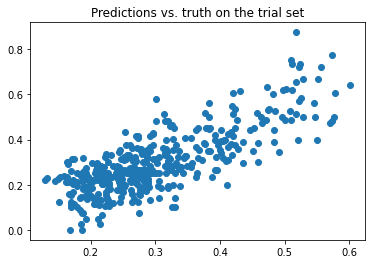

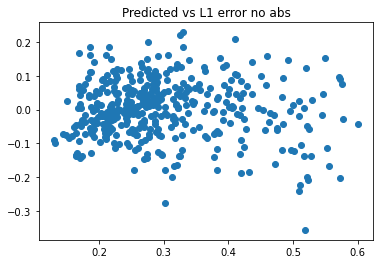

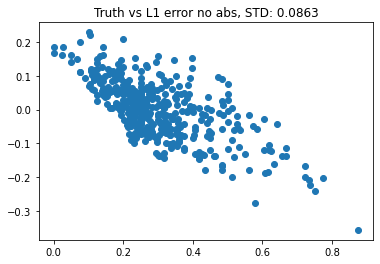

In [8]:
'''
No Features

Train R^2 0.6117951321590476
Train L1: 0.06483158278330525
Trial R^2: 0.6192870105416555
Trial L1: 0.07189836900564427
'''

linreg = LinearRegression()
linreg.fit(training_data, complexity)

predictions = linreg.predict(training_data)
print("Train R^2", linreg.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))

trial_predictions = linreg.predict(trial_data)

print("Trial R^2:", linreg.score(trial_data, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

plotCharts(trial_predictions, trial_complexity)

# SVR

Train R^2 0.7842005961992776
Train L1: 0.045305250002592654
Trial R^2: 0.6384430590140824
Trial L1: 0.06394639000357148


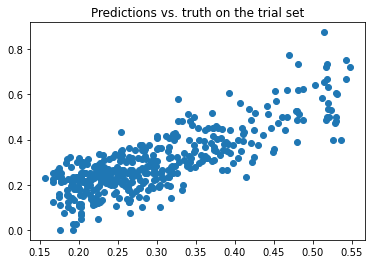

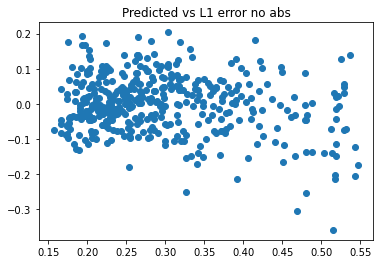

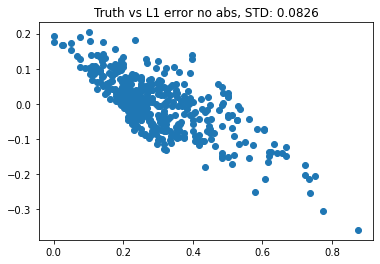

In [9]:
'''
Best thus far:
Train R^2 0.7842005961992776
Train L1: 0.045305250002592876
Trial R^2: 0.6384430590140824
Trial L1: 0.0639463900035714868
'''

from sklearn import svm

svrreg = svm.SVR(epsilon=0.02, C=0.1)
svrreg.fit(training_data, complexity)

predictions = svrreg.predict(training_data)
print("Train R^2", svrreg.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))

trial_predictions = svrreg.predict(trial_data)

print("Trial R^2:", svrreg.score(trial_data, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

plotCharts(trial_predictions, trial_complexity)

Train R^2 0.7412546555124988
Train L1: 0.05033152833400867
Trial R^2: 0.6562085265760065
Trial L1: 0.06243549075439472


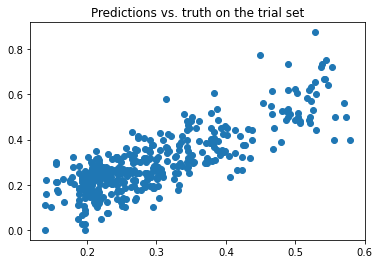

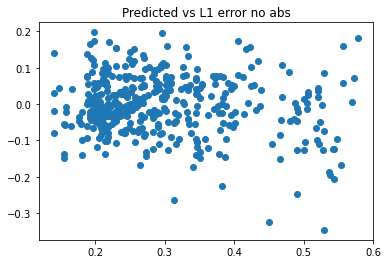

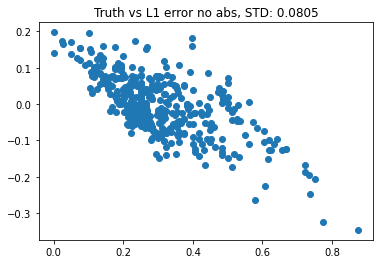

In [10]:
'''
Best thus far:
Train R^2 0.7412546555124988
Train L1: 0.05033152833400863
Trial R^2: 0.6562085265760065
Trial L1: 0.06243549075439472
'''
pca = PCA(n_components=50, random_state=0)

training_data_compressed = pca.fit_transform(training_data)
trial_data_compressed = pca.transform(trial_data)
svrreg = svm.SVR(epsilon=0.02, C=0.1)
svrreg.fit(training_data_compressed, complexity)

predictions = svrreg.predict(training_data_compressed)
print("Train R^2", svrreg.score(training_data_compressed, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))

trial_predictions = svrreg.predict(trial_data_compressed)

print("Trial R^2:", svrreg.score(trial_data_compressed, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

plotCharts(trial_predictions, trial_complexity)

# AdaBoost

[0.17197806 0.15820112 0.15820112 ... 0.5313683  0.60075111 0.50193253]
Train R^2 0.6546296016206434
Train L1: 0.06333190385065002
Trial R^2 0.5624847950344298
Trial L1: 0.06904159785031874


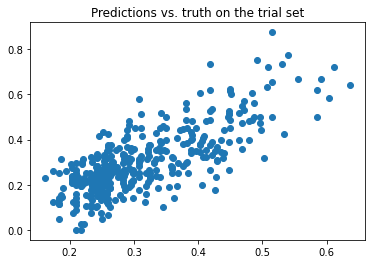

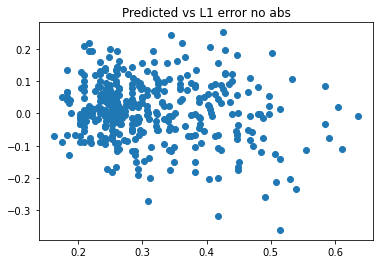

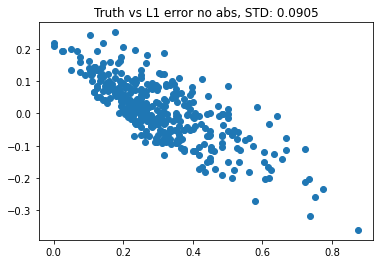

In [11]:
pca = PCA(n_components=50, random_state=0)

training_data_compressed = pca.fit_transform(training_data)
trial_data_compressed = pca.transform(trial_data)
adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5, random_state=0), n_estimators=50, random_state=0) # BaggingRegressor(base_estimator=LogisticRegression(), n_estimators=10, max_samples=0.5)
complexity = df['complexity'].values
adaboost.fit(training_data_compressed, complexity)

predictions = adaboost.predict(training_data_compressed)
trial_predictions = adaboost.predict(trial_data_compressed)

print(predictions)

print("Train R^2", adaboost.score(training_data_compressed, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))
print("Trial R^2", adaboost.score(trial_data_compressed, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

plotCharts(trial_predictions, trial_complexity)